# Understanding the execution flow from `LightningQubit`

In [1]:
from typing import Iterable, Union
import quimb.tensor as qtn
import pennylane as qml
from pennylane.wires import Wires
import numpy as np

/home/pietropaolo.frisoni/anaconda3/envs/PennyLane/lib/python3.9/site-packages/cotengra/hyperoptimizers/hyper.py:34: UserWarning: Couldn't import `kahypar` - skipping from default hyper optimizer and using basic `labels` method instead.
  warnings.warn(


## Approach 1: choosing a tape

In [2]:
theta = 0.1
phi = 0.2

O1 = qml.Identity(wires=[0])
O2 = qml.PauliZ(wires=[1])

ops = [
    qml.DoubleExcitation(phi, wires=[12, 11, 0, 9]),
    qml.PauliX(wires=[0]),
    qml.RX(theta, wires=[0]),
    qml.qml.CSWAP(wires=[7, 0, 5]),
    qml.RX(phi, wires=[1]),
    qml.CNOT(wires=[3, 4]),
    qml.DoubleExcitation(phi, wires=[1, 2, 3, 4]),
    qml.qml.CSWAP(wires=[0, 1, 2]),
    qml.Hadamard(wires=[4]),
    qml.qml.CSWAP(wires=[2, 3, 4]),
    qml.CNOT(wires=[2, 4]),
    qml.DoubleExcitation(phi, wires=[0, 1, 3, 4]),
]

meas = [
    qml.expval(O2),
    qml.expval(O2),
    qml.var(qml.PauliY(wires=[2])),
    qml.expval(O1),
    qml.var(qml.PauliY(wires=[4])),
]


tape = qml.tape.QuantumScript(ops=ops, measurements=meas)

In [3]:
tape.wires

<Wires = [12, 11, 0, 9, 7, 5, 1, 3, 4, 2]>

In [4]:
tape.operations

[DoubleExcitation(0.2, wires=[12, 11, 0, 9]),
 X(0),
 RX(0.1, wires=[0]),
 CSWAP(wires=[7, 0, 5]),
 RX(0.2, wires=[1]),
 CNOT(wires=[3, 4]),
 DoubleExcitation(0.2, wires=[1, 2, 3, 4]),
 CSWAP(wires=[0, 1, 2]),
 Hadamard(wires=[4]),
 CSWAP(wires=[2, 3, 4]),
 CNOT(wires=[2, 4]),
 DoubleExcitation(0.2, wires=[0, 1, 3, 4])]

In [5]:
tape.observables

[Z(1), Z(1), Y(2), I(0), Y(4)]

In [6]:
tape.measurements

[expval(Z(1)), expval(Z(1)), var(Y(2)), expval(I(0)), var(Y(4))]

In [7]:
tape.wires

<Wires = [12, 11, 0, 9, 7, 5, 1, 3, 4, 2]>

In [8]:
dev = qml.device("lightning.qubit", wires=tape.wires)

dev.execute(circuits=tape)

Frisus log: execute called with:
execution_config=ExecutionConfig(grad_on_execution=None, use_device_gradient=None, use_device_jacobian_product=None, gradient_method=None, gradient_keyword_arguments={}, device_options={}, interface=None, derivative_order=1)
circuits=(<QuantumScript: wires=[12, 11, 0, 9, 7, 5, 1, 3, 4, 2], params=5>,)



(0.9999502079587257, 0.9999502079587257, 0.9901818584603551, 1.0, 1.0)

## Learning from `LightningQubit` using Python API

In [9]:
from pennylane_lightning.lightning_qubit import LightningQubit

In [10]:
obj = LightningQubit(wires=tape.wires)

In [11]:
obj.tracker

In [12]:
obj.execute(tape)

Frisus log: execute called with:
execution_config=ExecutionConfig(grad_on_execution=None, use_device_gradient=None, use_device_jacobian_product=None, gradient_method=None, gradient_keyword_arguments={}, device_options={}, interface=None, derivative_order=1)
circuits=(<QuantumScript: wires=[12, 11, 0, 9, 7, 5, 1, 3, 4, 2], params=5>,)



(0.9999502079587257, 0.9999502079587257, 0.9901818584603551, 1.0, 1.0)

## Testing `LightningTensor` 

In [13]:
wires = tape.wires
backend = "quimb"
method = "mps"
c_dtype = np.complex128
max_bond_dim = None
cutoff = 0.0

In [14]:
from pennylane_lightning.lightning_tensor import LightningTensor

In [15]:
obj = LightningTensor(
    wires=wires,
    backend=backend,
    method=method,
    c_dtype=c_dtype,
    max_bond_dim=max_bond_dim,
    cutoff=cutoff,
)

In [16]:
obj._interface.state

MatrixProductState(tensors=10, indices=19, L=10, max_bond=2)

In [17]:
# obj._interface._circuitMPS.get_psi_reverse_lightcone(3)

In [18]:
# type(obj._setup_execution_config())

In [19]:
# program, config = obj.preprocess()

In [20]:
# config.device_options

In [21]:
obj.execute(circuits=tape)

(0.9999502079587207,
 0.9999502079587207,
 0.9901818584603503,
 0.9999999999999949,
 0.9999999999999951)

In [22]:
obj._interface._circuitMPS.gates

[<Gate(label=RAW139952805069808, params=raw, qubits=(2, 3))>,
 <Gate(label=RAW139952805069808, params=raw, qubits=(0, 2))>,
 <Gate(label=RAW139953862818864, params=raw, qubits=(3,))>,
 <Gate(label=RAW139953862818864, params=raw, qubits=(0,))>,
 <Gate(label=RAW139952805069808, params=raw, qubits=(2, 3))>,
 <Gate(label=RAW139952805069808, params=raw, qubits=(0, 1))>,
 <Gate(label=RAW139952804769680, params=raw, qubits=(1,))>,
 <Gate(label=RAW139952804784528, params=raw, qubits=(0,))>,
 <Gate(label=RAW139952805069808, params=raw, qubits=(0, 3))>,
 <Gate(label=RAW139953862818864, params=raw, qubits=(3,))>,
 <Gate(label=RAW139952805069808, params=raw, qubits=(3, 1))>,
 <Gate(label=RAW139952804372368, params=raw, qubits=(1,))>,
 <Gate(label=RAW139952805070192, params=raw, qubits=(0,))>,
 <Gate(label=RAW139952805069808, params=raw, qubits=(2, 1))>,
 <Gate(label=RAW139952805069808, params=raw, qubits=(2, 0))>,
 <Gate(label=RAW139952804865008, params=raw, qubits=(1,))>,
 <Gate(label=RAW13995280

In [61]:
obj._interface._circuitMPS.psi.tags

oset(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'I0', 'I1', 'I2', 'I3', 'I4', 'I5', 'I6', 'I7', 'I8', 'I9', 'PSI0', 'GATE_2', 'GATE_3', 'GATE_6', 'GATE_7', 'GATE_9', 'GATE_11', 'GATE_12', 'GATE_15', 'GATE_16', 'GATE_18', 'GATE_20', 'GATE_21', 'GATE_24', 'GATE_25', 'GATE_28', 'GATE_29', 'GATE_30', 'GATE_32', 'GATE_34', 'GATE_36', 'GATE_38', 'GATE_39', 'GATE_41', 'GATE_42', 'GATE_43', 'GATE_45', 'GATE_47', 'GATE_49', 'GATE_51', 'GATE_53', 'GATE_54', 'GATE_56', 'GATE_57', 'GATE_58', 'GATE_60', 'GATE_62', 'GATE_64', 'GATE_66', 'GATE_68', 'GATE_69', 'GATE_71', 'GATE_72', 'GATE_73', 'GATE_75', 'GATE_79', 'GATE_80', 'GATE_83', 'GATE_84', 'GATE_86', 'GATE_88', 'GATE_89', 'GATE_92', 'GATE_93', 'GATE_95', 'GATE_97', 'GATE_98', 'GATE_101', 'GATE_102', 'GATE_105', 'GATE_107', 'GATE_109', 'GATE_111', 'GATE_113', 'GATE_114', 'GATE_116', 'GATE_117', 'GATE_118', 'GATE_120', 'GATE_122', 'GATE_124', 'GATE_126', 'GATE_128', 'GATE_129', 'GATE_131', 'GATE_132', 'GATE_133', 'GATE_135', 'GATE_137', '

In [24]:
obj._interface.state

MatrixProductState(tensors=10, indices=19, L=10, max_bond=32)

In [25]:
obj._interface._circuitMPS.__dict__

{'_psi': MatrixProductState(tensors=10, indices=19, L=10, max_bond=32),
 'N': 10,
 'gate_opts': {'contract': 'swap+split', 'propagate_tags': 'register'},
 'gates': [<Gate(label=RAW139952805069808, params=raw, qubits=(2, 3))>,
  <Gate(label=RAW139952805069808, params=raw, qubits=(0, 2))>,
  <Gate(label=RAW139953862818864, params=raw, qubits=(3,))>,
  <Gate(label=RAW139953862818864, params=raw, qubits=(0,))>,
  <Gate(label=RAW139952805069808, params=raw, qubits=(2, 3))>,
  <Gate(label=RAW139952805069808, params=raw, qubits=(0, 1))>,
  <Gate(label=RAW139952804769680, params=raw, qubits=(1,))>,
  <Gate(label=RAW139952804784528, params=raw, qubits=(0,))>,
  <Gate(label=RAW139952805069808, params=raw, qubits=(0, 3))>,
  <Gate(label=RAW139953862818864, params=raw, qubits=(3,))>,
  <Gate(label=RAW139952805069808, params=raw, qubits=(3, 1))>,
  <Gate(label=RAW139952804372368, params=raw, qubits=(1,))>,
  <Gate(label=RAW139952805070192, params=raw, qubits=(0,))>,
  <Gate(label=RAW139952805069808

In [26]:
obj._interface._circuitMPS

<Circuit(n=10, num_gates=225, gate_opts={'contract': 'swap+split', 'propagate_tags': 'register'})>

In [27]:
obj._interface._circuitMPS.psi.max_bond()

32

In [62]:
obj._interface._circuitMPS.psi

MatrixProductState(tensors=10, indices=19, L=10, max_bond=32)

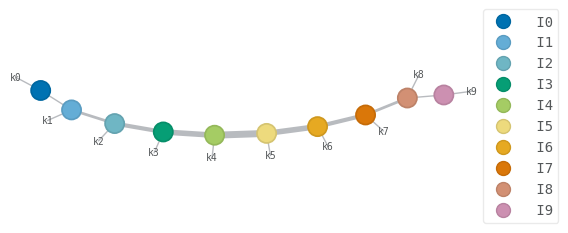

In [29]:
obj._interface.draw_state()

In [30]:
obj._interface._circuitMPS.psi.to_dense()

array([[ 2.87656541e-16-3.51640537e-02j],
       [-4.91947293e-16-3.19231147e-16j],
       [-6.98796420e-16-3.51640537e-02j],
       ...,
       [ 3.17165618e-18+4.00406344e-18j],
       [-3.35626407e-17+3.13200683e-17j],
       [-1.01539697e-17+3.68037979e-18j]])

In [31]:
# obj.compute_derivatives(tape)

In [32]:
# obj._interface.state_to_array()

In [33]:
obj._interface._circuitMPS._psi

MatrixProductState(tensors=10, indices=19, L=10, max_bond=32)

# Playing with `quimb`

In [34]:
wires = Wires(range(7))

init_state = qtn.MPS_computational_state(
    "0" * len(wires), tags=[str(l) for l in wires.labels]
)

qc = qtn.CircuitMPS(psi0=init_state)

op = qml.CNOT(wires=[0, 1])

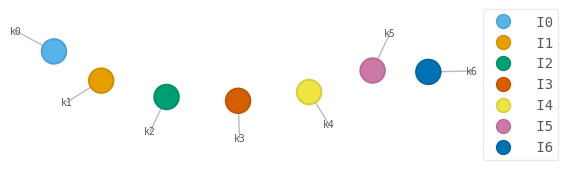

In [35]:
qc.psi.draw(color=[f"I{q}" for q in range(len(wires))], show_tags=False, show_inds=True)

In [36]:
init_state.gate_

functools.partial(<bound method gate_TN_1D of MatrixProductState(tensors=7, indices=13, L=7, max_bond=2)>, inplace=True)

In [37]:
qc.amplitude("0111111")

0j

In [38]:
init_state

MatrixProductState(tensors=7, indices=13, L=7, max_bond=2)

In [39]:
qc.ket_site_ind

<function str.format>

In [40]:
qc.__dict__

{'_psi': MatrixProductState(tensors=7, indices=7, L=7, max_bond=2),
 'N': 7,
 'gate_opts': {'contract': 'swap+split', 'propagate_tags': 'register'},
 'gates': [],
 '_ket_site_ind_id': 'k{}',
 '_bra_site_ind_id': 'b{}',
 'ket_site_ind': <function str.format>,
 'bra_site_ind': <function str.format>,
 '_sample_n_gates': 0,
 '_storage': {('psi_simplified',
   'ADCRS',
   1e-12): MatrixProductState(tensors=7, indices=7, L=7, max_bond=2)},
 '_sampled_conditionals': {},
 '_marginal_storage_size': 0}

In [41]:
qc.gates

[]

In [42]:
gate = qtn.circuit.parse_to_gate(op.matrix(), tuple(op.wires))

In [43]:
gate

<Gate(label=RAW139952805069808, params=raw, qubits=((0, 1),))>

In [44]:
qtn.MPS_computational_state("0" * len(wires), tags=[str(l) for l in wires.labels])

MatrixProductState(tensors=7, indices=13, L=7, max_bond=2)

In [45]:
qtn.MPS_zero_state(bond_dim=6, L=9)

MatrixProductState(tensors=9, indices=17, L=9, max_bond=6)

In [46]:
qtn.MPS_rand_state(L=9, bond_dim=6)

MatrixProductState(tensors=9, indices=17, L=9, max_bond=6)

In [47]:
ops = {
    "Identity": qml.Identity(wires=[0]),
    "BlockEncode": qml.BlockEncode([[0.1, 0.2], [0.3, 0.4]], wires=[0, 1]),
    "CNOT": qml.CNOT(wires=[0, 1]),
    "CRX": qml.CRX(0, wires=[0, 1]),
    "CRY": qml.CRY(0, wires=[0, 1]),
    "CRZ": qml.CRZ(0, wires=[0, 1]),
    "CRot": qml.CRot(0, 0, 0, wires=[0, 1]),
    "CSWAP": qml.CSWAP(wires=[0, 1, 2]),
    "CZ": qml.CZ(wires=[0, 1]),
    "CCZ": qml.CCZ(wires=[0, 1, 2]),
    "CY": qml.CY(wires=[0, 1]),
    "CH": qml.CH(wires=[0, 1]),
    "DiagonalQubitUnitary": qml.DiagonalQubitUnitary(np.array([1, 1]), wires=[0]),
    "Hadamard": qml.Hadamard(wires=[0]),
    "MultiRZ": qml.MultiRZ(0, wires=[0]),
    "PauliX": qml.X(0),
    "PauliY": qml.Y(0),
    "PauliZ": qml.Z(0),
    "X": qml.X([0]),
    "Y": qml.Y([0]),
    "Z": qml.Z([0]),
    "PhaseShift": qml.PhaseShift(0, wires=[0]),
    "PCPhase": qml.PCPhase(0, 1, wires=[0, 1]),
    "ControlledPhaseShift": qml.ControlledPhaseShift(0, wires=[0, 1]),
    "CPhaseShift00": qml.CPhaseShift00(0, wires=[0, 1]),
    "CPhaseShift01": qml.CPhaseShift01(0, wires=[0, 1]),
    "CPhaseShift10": qml.CPhaseShift10(0, wires=[0, 1]),
    "QubitUnitary": qml.QubitUnitary(np.eye(2), wires=[0]),
    "SpecialUnitary": qml.SpecialUnitary(np.array([0.2, -0.1, 2.3]), wires=1),
    "ControlledQubitUnitary": qml.ControlledQubitUnitary(
        np.eye(2), control_wires=[1], wires=[0]
    ),
    "MultiControlledX": qml.MultiControlledX(wires=[1, 2, 0]),
    "IntegerComparator": qml.IntegerComparator(1, geq=True, wires=[0, 1, 2]),
    "RX": qml.RX(0, wires=[0]),
    "RY": qml.RY(0, wires=[0]),
    "RZ": qml.RZ(0, wires=[0]),
    "Rot": qml.Rot(0, 0, 0, wires=[0]),
    "S": qml.S(wires=[0]),
    "Adjoint(S)": qml.adjoint(qml.S(wires=[0])),
    "SWAP": qml.SWAP(wires=[0, 1]),
    "ISWAP": qml.ISWAP(wires=[0, 1]),
    "PSWAP": qml.PSWAP(0, wires=[0, 1]),
    "ECR": qml.ECR(wires=[0, 1]),
    "Adjoint(ISWAP)": qml.adjoint(qml.ISWAP(wires=[0, 1])),
    "T": qml.T(wires=[0]),
    "Adjoint(T)": qml.adjoint(qml.T(wires=[0])),
    "SX": qml.SX(wires=[0]),
    "Adjoint(SX)": qml.adjoint(qml.SX(wires=[0])),
    "Toffoli": qml.Toffoli(wires=[0, 1, 2]),
    "QFT": qml.templates.QFT(wires=[0, 1, 2]),
    "IsingXX": qml.IsingXX(0, wires=[0, 1]),
    "IsingYY": qml.IsingYY(0, wires=[0, 1]),
    "IsingZZ": qml.IsingZZ(0, wires=[0, 1]),
    "IsingXY": qml.IsingXY(0, wires=[0, 1]),
    "SingleExcitation": qml.SingleExcitation(0, wires=[0, 1]),
    "SingleExcitationPlus": qml.SingleExcitationPlus(0, wires=[0, 1]),
    "SingleExcitationMinus": qml.SingleExcitationMinus(0, wires=[0, 1]),
    "DoubleExcitation": qml.DoubleExcitation(0, wires=[0, 1, 2, 3]),
    "DoubleExcitationPlus": qml.DoubleExcitationPlus(0, wires=[0, 1, 2, 3]),
    "DoubleExcitationMinus": qml.DoubleExcitationMinus(0, wires=[0, 1, 2, 3]),
    "QubitCarry": qml.QubitCarry(wires=[0, 1, 2, 3]),
    "QubitSum": qml.QubitSum(wires=[0, 1, 2]),
    "PauliRot": qml.PauliRot(0, "XXYY", wires=[0, 1, 2, 3]),
    "U1": qml.U1(0, wires=0),
    "U2": qml.U2(0, 0, wires=0),
    "U3": qml.U3(0, 0, 0, wires=0),
    "SISWAP": qml.SISWAP(wires=[0, 1]),
    "Adjoint(SISWAP)": qml.adjoint(qml.SISWAP(wires=[0, 1])),
    "OrbitalRotation": qml.OrbitalRotation(0, wires=[0, 1, 2, 3]),
    "FermionicSWAP": qml.FermionicSWAP(0, wires=[0, 1]),
    "GlobalPhase": qml.GlobalPhase(0.123, wires=[0, 1]),
}

all_ops = ops.keys()

In [48]:
_operations = {
    "Identity",
    "QubitUnitary",
    "ControlledQubitUnitary",
    "MultiControlledX",
    "DiagonalQubitUnitary",
    "PauliX",
    "PauliY",
    "PauliZ",
    "MultiRZ",
    "GlobalPhase",
    "Hadamard",
    "S",
    "Adjoint(S)",
    "T",
    "Adjoint(T)",
    "SX",
    "Adjoint(SX)",
    "CNOT",
    "SWAP",
    "ISWAP",
    "PSWAP",
    "Adjoint(ISWAP)",
    "SISWAP",
    "Adjoint(SISWAP)",
    "SQISW",
    "CSWAP",
    "Toffoli",
    "CY",
    "CZ",
    "PhaseShift",
    "ControlledPhaseShift",
    "CPhase",
    "RX",
    "RY",
    "RZ",
    "Rot",
    "CRX",
    "CRY",
    "CRZ",
    "C(PauliX)",
    "C(PauliY)",
    "C(PauliZ)",
    "C(Hadamard)",
    "C(S)",
    "C(T)",
    "C(PhaseShift)",
    "C(RX)",
    "C(RY)",
    "C(RZ)",
    "C(Rot)",
    "C(SWAP)",
    "C(IsingXX)",
    "C(IsingXY)",
    "C(IsingYY)",
    "C(IsingZZ)",
    "C(SingleExcitation)",
    "C(SingleExcitationMinus)",
    "C(SingleExcitationPlus)",
    "C(DoubleExcitation)",
    "C(DoubleExcitationMinus)",
    "C(DoubleExcitationPlus)",
    "C(MultiRZ)",
    "C(GlobalPhase)",
    "CRot",
    "IsingXX",
    "IsingYY",
    "IsingZZ",
    "IsingXY",
    "SingleExcitation",
    "SingleExcitationPlus",
    "SingleExcitationMinus",
    "DoubleExcitation",
    "DoubleExcitationPlus",
    "DoubleExcitationMinus",
    "QubitCarry",
    "QubitSum",
    "OrbitalRotation",
    "QFT",
    "ECR",
    "BlockEncode",
}

In [49]:
for op in all_ops:
    if not ops[op].has_matrix:
        print(ops[op])
        continue
    if ops[op].name not in _operations:
        print(ops[op])

CCZ(wires=[0, 1, 2])
CH(wires=[0, 1])
PCPhase(0, wires=[0, 1])
CPhaseShift00(0, wires=[0, 1])
CPhaseShift01(0, wires=[0, 1])
CPhaseShift10(0, wires=[0, 1])
SpecialUnitary(array([ 0.2, -0.1,  2.3]), wires=[1])
IntegerComparator(wires=[0, 1, 2])
PauliRot(0, XXYY, wires=[0, 1, 2, 3])
U1(0, wires=[0])
U2(0, 0, wires=[0])
U3(0, 0, 0, wires=[0])
FermionicSWAP(0, wires=[0, 1])


In [50]:
for op in _operations:
    if op not in all_ops:
        print(op)

SQISW
C(SingleExcitationMinus)
C(IsingZZ)
C(T)
C(Rot)
C(RY)
C(SWAP)
CPhase
C(S)
C(PauliX)
C(IsingYY)
C(GlobalPhase)
C(SingleExcitationPlus)
C(DoubleExcitationMinus)
C(RZ)
C(IsingXX)
C(SingleExcitation)
C(DoubleExcitation)
C(RX)
C(PauliY)
C(MultiRZ)
C(IsingXY)
C(DoubleExcitationPlus)
C(PhaseShift)
C(Hadamard)
C(PauliZ)


In [51]:
for op in all_ops:
    if not ops[op].has_matrix:
        print(ops[op])
        assert False
    mat = ops[op].matrix()
    name = ops[op].name
    if mat.dtype == int:
        print(mat)
        print(name)

[[1 0 0 0]
 [0 1 0 0]
 [0 0 0 1]
 [0 0 1 0]]
CNOT
[[1 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0]
 [0 0 0 1 0 0 0 0]
 [0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 1 0]
 [0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 1]]
CSWAP
[[ 1  0  0  0]
 [ 0  1  0  0]
 [ 0  0  1  0]
 [ 0  0  0 -1]]
CZ
[[ 1  0  0  0  0  0  0  0]
 [ 0  1  0  0  0  0  0  0]
 [ 0  0  1  0  0  0  0  0]
 [ 0  0  0  1  0  0  0  0]
 [ 0  0  0  0  1  0  0  0]
 [ 0  0  0  0  0  1  0  0]
 [ 0  0  0  0  0  0  1  0]
 [ 0  0  0  0  0  0  0 -1]]
CCZ
[[1 0]
 [0 1]]
DiagonalQubitUnitary
[[0 1]
 [1 0]]
PauliX
[[ 1  0]
 [ 0 -1]]
PauliZ
[[0 1]
 [1 0]]
PauliX
[[ 1  0]
 [ 0 -1]]
PauliZ
[[1 0 0 0]
 [0 0 1 0]
 [0 1 0 0]
 [0 0 0 1]]
SWAP
[[1 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0]
 [0 0 0 1 0 0 0 0]
 [0 0 0 0 1 0 0 0]
 [0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 1 0]]
Toffoli
[[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0

In [52]:
assert isinstance(1.0, (float, np.ndarray))

In [53]:
result = 1.0

In [54]:
assert isinstance(result, (float, np.ndarray))

In [55]:
qml.DoubleExcitation(phi, wires=[7, 4, 5, 6]).decomposition()

[CNOT(wires=[5, 6]),
 CNOT(wires=[7, 5]),
 Hadamard(wires=[6]),
 Hadamard(wires=[7]),
 CNOT(wires=[5, 6]),
 CNOT(wires=[7, 4]),
 RY(0.025, wires=[4]),
 RY(-0.025, wires=[7]),
 CNOT(wires=[7, 6]),
 Hadamard(wires=[6]),
 CNOT(wires=[6, 4]),
 RY(0.025, wires=[4]),
 RY(-0.025, wires=[7]),
 CNOT(wires=[5, 4]),
 CNOT(wires=[5, 7]),
 RY(-0.025, wires=[4]),
 RY(0.025, wires=[7]),
 CNOT(wires=[6, 4]),
 Hadamard(wires=[6]),
 CNOT(wires=[7, 6]),
 RY(-0.025, wires=[4]),
 RY(0.025, wires=[7]),
 CNOT(wires=[7, 4]),
 CNOT(wires=[5, 7]),
 Hadamard(wires=[7]),
 Hadamard(wires=[6]),
 CNOT(wires=[7, 5]),
 CNOT(wires=[5, 6])]

In [56]:
ops = qml.Toffoli(wires=[2, 7, 5]).decomposition()

In [57]:
for op in ops:
    print(op.matrix())

[[ 0.70710678  0.70710678]
 [ 0.70710678 -0.70710678]]
[[1 0 0 0]
 [0 1 0 0]
 [0 0 0 1]
 [0 0 1 0]]
[[1.        -0.j         0.        -0.j        ]
 [0.        -0.j         0.70710678-0.70710678j]]
[[1 0 0 0]
 [0 1 0 0]
 [0 0 0 1]
 [0 0 1 0]]
[[1.        +0.j         0.        +0.j        ]
 [0.        +0.j         0.70710678+0.70710678j]]
[[1 0 0 0]
 [0 1 0 0]
 [0 0 0 1]
 [0 0 1 0]]
[[1.        -0.j         0.        -0.j        ]
 [0.        -0.j         0.70710678-0.70710678j]]
[[1 0 0 0]
 [0 1 0 0]
 [0 0 0 1]
 [0 0 1 0]]
[[1.        +0.j         0.        +0.j        ]
 [0.        +0.j         0.70710678+0.70710678j]]
[[1.        +0.j         0.        +0.j        ]
 [0.        +0.j         0.70710678+0.70710678j]]
[[1 0 0 0]
 [0 1 0 0]
 [0 0 0 1]
 [0 0 1 0]]
[[ 0.70710678  0.70710678]
 [ 0.70710678 -0.70710678]]
[[1.        +0.j         0.        +0.j        ]
 [0.        +0.j         0.70710678+0.70710678j]]
[[1.        -0.j         0.        -0.j        ]
 [0.        -0.j      

In [58]:
qml.DoubleExcitationPlus(phi, wires=[0, 2, 3, 4])

DoubleExcitationPlus(0.2, wires=[0, 2, 3, 4])

In [59]:
def decompose_with_property(op):
    # Check if the current operator meets the required property
    if len(op.wires) <= 2:
        return [op]

    # Decompose the operator and process each sub-operator recursively
    decomposed_ops = []
    for sub_op in op.decomposition():
        decomposed_ops.extend(decompose_with_property(sub_op))

    return decomposed_ops


# Example usage
op = qml.DoubleExcitation(phi, wires=[0, 2, 3, 4])
decomposed_ops = decompose_with_property(op)

In [60]:
decomposed_ops

[CNOT(wires=[3, 4]),
 CNOT(wires=[0, 3]),
 Hadamard(wires=[4]),
 Hadamard(wires=[0]),
 CNOT(wires=[3, 4]),
 CNOT(wires=[0, 2]),
 RY(0.025, wires=[2]),
 RY(-0.025, wires=[0]),
 CNOT(wires=[0, 4]),
 Hadamard(wires=[4]),
 CNOT(wires=[4, 2]),
 RY(0.025, wires=[2]),
 RY(-0.025, wires=[0]),
 CNOT(wires=[3, 2]),
 CNOT(wires=[3, 0]),
 RY(-0.025, wires=[2]),
 RY(0.025, wires=[0]),
 CNOT(wires=[4, 2]),
 Hadamard(wires=[4]),
 CNOT(wires=[0, 4]),
 RY(-0.025, wires=[2]),
 RY(0.025, wires=[0]),
 CNOT(wires=[0, 2]),
 CNOT(wires=[3, 0]),
 Hadamard(wires=[0]),
 Hadamard(wires=[4]),
 CNOT(wires=[0, 3]),
 CNOT(wires=[3, 4])]